### Get the packages

In [2]:
import pandas as pd
import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob
from datetime import datetime
# from xgboost import XGBClassifier

In [3]:
def analize_sentiment(tweet):
    analysis = TextBlob((str(tweet)))
    return analysis.polarity


### Get the path for the CSV and put it in here

In [4]:
news = pd.read_csv('J-F_input.csv')

FileNotFoundError: [Errno 2] File J-F_input.csv does not exist: 'J-F_input.csv'

In [32]:
def get_train_news(day, month, year):
    index = 0
    dataset = []
    d1 = datetime(year, month, day).date() 
    for date in news['Date']:
        d = datetime.strptime(date, '%Y-%m-%d').date()
        if d1 > d:
            dataset.append(news.iloc[index])
        index = index +1
        df = pd.DataFrame(dataset)
    return df
    

In [33]:
def get_test_news(day, month, year):
    index = 0
    dataset = []
    d1 = datetime(year, month, day).date() 
    for date in news['Date']:
        d = datetime.strptime(date, '%Y-%m-%d').date()
        if d1 < d:
            dataset.append(news.iloc[index])
        index = index +1
        df = pd.DataFrame(dataset)
    return df
    

In [49]:
num_column = (len(news.columns))
# day, month, year
train_news = get_train_news(8, 2, 2019)
test_news = get_test_news(7, 2, 2019)

          Date  Label                      1                      2  \
26  2019-02-08      1     [8.06005899999991]   [-5.450072999999975]   
27  2019-02-11      1  [-1.9399410000000898]     [8.06005899999991]   
28  2019-02-12      1   [14.569946000000073]  [-1.9399410000000898]   
29  2019-02-13      1   [-4.829956000000038]   [14.569946000000073]   
30  2019-02-14      1    [3.619995000000017]   [-4.829956000000038]   
31  2019-02-15      1  [-16.429932000000008]    [3.619995000000017]   
32  2019-02-19      1                     []     [8.56005899999991]   
33  2019-02-20      1    [-6.18994100000009]                     []   
34  2019-02-21      1  [-13.869995000000017]    [-6.18994100000009]   
35  2019-02-22      1    [9.469970999999987]  [-13.869995000000017]   
36  2019-02-25      1    [-6.59997599999997]    [9.469970999999987]   
37  2019-02-26      1    [9.380004999999983]    [-6.59997599999997]   
38  2019-02-27      1    [9.100097999999889]    [9.380004999999983]   

     

In [35]:
train_news_list = []

In [36]:
for row in range (0, len(train_news.index)):
    train_news_list.append(' '.join(str(k) for k in train_news.iloc[row,12:num_column]))

In [37]:
vectorize = CountVectorizer(min_df=0.01, max_df=0.8)
news_vector = vectorize.fit_transform(train_news_list)

In [38]:
print("THE TABLE OF FREQUENCY WORD DISTRIBUTION", news_vector.shape)

THE TABLE OF FREQUENCY WORD DISTRIBUTION (26, 43)


In [39]:
lr = LogisticRegression()
model = lr.fit(news_vector, train_news["Label"])


In [40]:
test_news_list = []
for row in range(0, len(test_news.index)):
    test_news_list.append(' '.join(str(x) for x in test_news.iloc[row,2:num_column]))

In [41]:
test_vector = vectorize.transform(test_news_list)

In [42]:
predictions = model.predict(test_vector)
pd.crosstab(test_news["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,1
Actual,
1,13


In [43]:
accuracy1=accuracy_score(test_news["Label"], predictions)
print("the baseline model accuracy", accuracy1)

the baseline model accuracy 1.0


In [44]:
words = vectorize.get_feature_names()
coefficients = model.coef_.tolist()[0]
coeffdf = pd.DataFrame({'Word' : words, 'Coefficient' : coefficients})

In [45]:
coeffdf = coeffdf.sort_values(['Coefficient', 'Word'], ascending=[0,1])
print("Top ten words according to the baseline model", coeffdf.head(10))
print("Last ten words according to the baseline model", coeffdf.tail(10))

Top ten words according to the baseline model           Word  Coefficient
1          and     0.260800
0      accused     0.161308
2        board     0.161308
9    executive     0.161308
10        exit     0.161308
27        over     0.161308
28     package     0.161308
33        sued     0.161308
3   capitalism     0.150308
11    facebook     0.150308
Last ten words according to the baseline model         Word  Coefficient
23        my    -0.239453
25        of    -0.239453
26        on    -0.239453
38  tracking    -0.239453
14      have    -0.251495
17      made    -0.251495
20     money    -0.251495
21      much    -0.251495
37     today    -0.251495
42       you    -0.251495


In [46]:
nvectorize = TfidfVectorizer(min_df=0.01, max_df=0.90, ngram_range=(2,2))
news_nvector = nvectorize.fit_transform(train_news_list)
print("TFID TRANSFORMATION DATAFRAME SHAPE", news_nvector.shape)
nmodel = lr.fit(news_nvector, train_news["Label"])
test_news_list = []
for row in range (0,len(test_news.index)):
    test_news_list.append(' '.join(str(x) for x in test_news.iloc[row,2:num_column]))
ntest_vector = nvectorize.transform(test_news_list)
npredictions = nmodel.predict(ntest_vector)
pd.crosstab(test_news["Label"], npredictions, rownames=["Actual"], colnames=["Predicted"])
accuracy2 = accuracy_score(test_news['Label'], npredictions)
print("Logistics Regression with Bigram and TFID", accuracy2)
nwords = nvectorize.get_feature_names()
ncoefficients = nmodel.coef_.tolist()[0]
ncoeffdf = pd.DataFrame({'Word':nwords, 'Coefficient':ncoefficients})
ncoeffdf = ncoeffdf.sort_values(['Coefficient', 'Word'], ascending=[0,1])
ncoeffdf.head(10)
ncoeffdf.tail(10)
print(ncoeffdf.head(10))
print(ncoeffdf.tail(10))

TFID TRANSFORMATION DATAFRAME SHAPE (26, 45)
Logistics Regression with Bigram and TFID 1.0
                 Word  Coefficient
12         google and     0.151491
0   accused executive     0.099972
3          board sued     0.099972
8        exit package     0.099972
10        for accused     0.099972
13        google exit     0.099972
29        over google     0.099972
30        package for     0.099972
35          sued over     0.099972
1        and facebook     0.089316
            Word  Coefficient
20      made for    -0.187186
21   marriage on    -0.187186
22    money have    -0.187186
23    much money    -0.187186
25   my marriage    -0.187186
27         of my    -0.187186
28     on google    -0.187186
38    the demise    -0.187186
40  tracking the    -0.187186
44     you today    -0.187186


In [47]:
nvectorize = TfidfVectorizer(min_df=0.01, max_df=0.95, ngram_range=(2,2))
news_nvector = nvectorize.fit_transform(train_news_list)

rfmodel = RandomForestClassifier(random_state = 100)
rfmodel = rfmodel.fit(news_nvector, train_news["Label"])
test_news_list = []
for row in range(0, len(test_news.index)):
    test_news_list.append(' '.join(str(x) for x in test_news.iloc[row,2:num_column]))
ntest_vector = nvectorize.transform(test_news_list)

rfpredictions = rfmodel.predict(ntest_vector)
accuracyrf = accuracy_score(test_news["Label"], rfpredictions)
print("Random forest with tfid and bigram", accuracyrf)

Random forest with tfid and bigram 1.0


In [176]:
nvectorize = TfidfVectorizer(min_df=0.01, max_df=0.9,ngram_range=(2,2))
news_nvector = nvectorize.fit_transform(train_news_list)

nbmodel = MultinomialNB(alpha=0.5)
nbmodel = nbmodel.fit(news_nvector, train_news["Label"])

test_news_list = []
for row in range(0, len(test_news.index)):
    test_news_list.append(' '.join(str(x) for x in test_news.iloc[row,2:num_column]))
ntest_vector = nvectorize.transform(test_news_list)

nbpredictions = nbmodel.predict(ntest_vector)
nbaccuracy = accuracy_score(test_news['Label'], nbpredictions)
print("Naive Bayes accuracy: ", nbaccuracy)

Naive Bayes accuracy:  0.5203619909502263


In [177]:
gbmodel = GradientBoostingClassifier(random_state = 52)
gbmodel = gbmodel.fit(news_nvector, train_news["Label"])

test_news_list = []
for row in range(0, len(test_news.index)):
    test_news_list.append(' '.join(str(x) for x in test_news.iloc[row,2:num_column]))
ntest_vector = nvectorize.transform(test_news_list)

gbpredictions = gbmodel.predict(ntest_vector.toarray())
gbaccuracy = accuracy_score(test_news['Label'], gbpredictions)

In [178]:
print("CONFUSION MATRIX OF THE GRADIANT BOOSTING")
print(confusion_matrix(test_news['Label'], gbpredictions))

print("Gradient boosting accuracy: ", gbaccuracy)

CONFUSION MATRIX OF THE GRADIANT BOOSTING
[[  5 104]
 [  2 110]]
Gradient boosting accuracy:  0.5203619909502263


In [179]:
n3vectorize = TfidfVectorizer(min_df=0.0001, max_df=0.9, ngram_range=(3,3))
news_n3vector = n3vectorize.fit_transform(train_news_list)
print(news_n3vector.shape)

n3model = lr.fit(news_n3vector, train_news["Label"])

test_news_list = []
for row in range(0, len(test_news.index)):
    
#     print("P" ,' '.join(str(x) for x in test_news.iloc[row,12:num_column]) )
    test_news_list.append(' '.join(str(x) for x in test_news.iloc[row,2:num_column]))
n3test_vector = n3vectorize.transform(test_news_list)

n3predictions = n3model.predict(n3test_vector)

pd.crosstab(test_news["Label"], n3predictions, rownames=["Actual"], colnames=["Predicted"])

accuracy3 = accuracy_score(test_news['Label'], n3predictions)
print("TRIGRAM ACCURACY", accuracy3)

n3words = n3vectorize.get_feature_names()
n3coefficients = n3model.coef_.tolist()[0]
n3coeffdf = pd.DataFrame({'Word':n3words, 'Coefficient':n3coefficients})
n3coeffdf = n3coeffdf.sort_values(['Coefficient', 'Word'], ascending=[0,1])
print("trigram top ten word distribution", n3coeffdf.head(10))
print("trigarm last ten word distribution", n3coeffdf.tail(10))

(511, 2074)
TRIGRAM ACCURACY 0.48868778280542985
trigram top ten word distribution                       Word  Coefficient
712    google and facebook     0.496507
849     google returns nan     0.277174
1512       returns nan nan     0.277174
23       accuses google of     0.206461
36             ads nan nan     0.204936
106   and google translate     0.200160
138     apple hires google     0.195991
341          chief nan nan     0.195991
741       google chief nan     0.195991
952     hires google chief     0.195991
trigarm last ten word distribution                          Word  Coefficient
431              data nan nan    -0.222465
254      brexit your thursday    -0.238365
730        google brexit your    -0.238365
1880     turkey google brexit    -0.238365
515         employees nan nan    -0.247015
2060     your monday briefing    -0.251982
1964             week in tech    -0.256469
816            google nan nan    -0.268628
2066  your wednesday briefing    -0.285282
53         a

In [180]:
train_sentiment = train_news
test_sentiment = test_news
# train_sentiment = train_sentiment.drop(['Date', 'Label'], axis=1)
train_sentiment = train_sentiment.drop(['Date', 'Label', '1', '2', '3', '4', '5', '6', '7', '8', '9','10'], axis=1)
for column in train_sentiment:
    train_sentiment[column] = train_sentiment[column].apply(analize_sentiment)
train_sentiment = train_sentiment + 10

# test_sentiment = test_sentiment.drop(['Date', 'Label'], axis=1)
test_sentiment = test_sentiment.drop(['Date', 'Label', '1', '2', '3', '4', '5', '6', '7', '8', '9','10'], axis=1)
for column in test_sentiment:
    test_sentiment[column] = test_sentiment[column].apply(analize_sentiment)
test_sentiment = test_sentiment + 10

XGB_model = XGBClassifier()
gradiant = XGB_model.fit(train_sentiment, train_news['Label'])
y_pred = gradiant.predict(test_sentiment)

1 nan
1 nan
1 sharing online albums with google photos
2 sharing online albums with google photos
1 google memo author sues, claiming bias against white conservative men
2 google memo author sues, claiming bias against white conservative men
1 nan
1 nan
1 nan
1 changing country codes with google
2 changing country codes with google
1 nan
1 google sells a.i. for building a.i. (novices welcome)
2 google sells a.i. for building a.i. (novices welcome)
1 nan
1 nan
1 nan
1 the google lunar x prize’s race to the moon is over. nobody won.
2 the google lunar x prize’s race to the moon is over. nobody won.
1 using drones and netflix in the andes, but sidestepping google maps
2 using drones and netflix in the andes, but sidestepping google maps
1 nan
1 sharing events from other google calendars
2 sharing events from other google calendars
1 nan
1 nan
1 nan
1 nan
1 adding captions to images in google photos
2 adding captions to images in google photos
1 nan
1 nan
1 $2.4 billion deal for chelsea ma

1 nan
1 nan
1 nan
1 nan
1 nan
1 firm led by google veterans uses a.i. to ‘nudge’ workers toward happiness
2 firm led by google veterans uses a.i. to ‘nudge’ workers toward happiness
1 nan
1 nan
1 tracking the demise of my marriage on google maps
2 tracking the demise of my marriage on google maps
1 nan
1 nan
1 nan
1 nan
1 board sued over google’s exit package for accused executive
2 board sued over google’s exit package for accused executive
1 nan
1 nan
1 o.k., google: how much money have i made for you today?
2 o.k., google: how much money have i made for you today?
1 nan
1 the week in tech: how google and facebook spawned surveillance capitalism
2 the week in tech: how google and facebook spawned surveillance capitalism
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 google and waze must stop sharing drunken-driving checkpoints, new york police demand
2 google and waze must stop sharing drunken-driving checkpoints, new york police demand
1 nan
1 nan
1 nan
1 nan
1 

1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 apple unveils new ipad to catch google in the classroom
2 apple unveils new ipad to catch google in the classroom
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 google’s parent company spends like it’s thinking of a future beyond ads
2 google’s parent company spends like it’s thinking of a future beyond ads
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 google’s diversity efforts, charted
2 google’s diversity efforts, charted
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 the google translate world cup
2 the google translate world cup
1 nan
1 nan
1 thai boys, google fine, maria butina: your thursday briefing
2 thai boys, google fine, maria butina: you

1 nan
1 nan
1 nan
1 nan
1 as huawei loses google, the u.s.-china tech cold war gets its iron curtain
2 as huawei loses google, the u.s.-china tech cold war gets its iron curtain
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 turkey, google, brexit: your thursday briefing
2 turkey, google, brexit: your thursday briefing
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 na

1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 na

1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 []
2 []
1 [12.800048999999944]
2 [12.800048999999944]
1 [44.20996100000002]
2 [44.20996100000002]
1 [12.239990000000034]
2 [12.239990000000034]
1 [-0.7399900000000343]
2 [-0.7399900000000343]
1 [2.1699210000001585]
2 [2.1699210000001585]
1 [3.099975000000086]
2 [3.099975000000086]
1 [-8.13000499999998

1 [-28.619995000000017]
2 [-28.619995000000017]
1 [-15.280029000000013]
2 [-15.280029000000013]
1 [-19.72497599999997]
2 [-19.72497599999997]
1 [5.43994100000009]
2 [5.43994100000009]
1 [-34.64001499999995]
2 [-34.64001499999995]
1 [-0.4699709999999868]
2 [-0.4699709999999868]
1 [-38.02001999999993]
2 [-38.02001999999993]
1 [-8.900024999999914]
2 [-8.900024999999914]
1 [15.369995000000017]
2 [15.369995000000017]
1 [-43.57006799999999]
2 [-43.57006799999999]
1 [17.260009999999966]
2 [17.260009999999966]
1 [12.329956000000038]
2 [12.329956000000038]
1 [-9.68994100000009]
2 [-9.68994100000009]
1 [-1.0600589999999102]
2 [-1.0600589999999102]
1 [2.799927000000025]
2 [2.799927000000025]
1 [5.819946000000073]
2 [5.819946000000073]
1 [-3.6099850000000515]
2 [-3.6099850000000515]
1 [19.81005899999991]
2 [19.81005899999991]
1 [-22.14001499999995]
2 [-22.14001499999995]
1 [-4.0]
2 [-4.0]
1 [20.840087999999923]
2 [20.840087999999923]
1 [20.52001999999993]
2 [20.52001999999993]
1 [26.15002400000003

1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 facebook, google and twitter rebel against pakistan’s censorship rules
2 facebook, google and twitter rebel against pakistan’s censorship rules
1 nan
1 nan
1 nan
1 nan
1 star engineer who crossed google is ordered to pay $179 million to company
2 star engineer who crossed google is ordered to pay $179 million to company
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 chinese hackers target email accounts of biden campaign staff, google says
2 chinese hackers target email accounts of biden campaign staff, google says
1 nan
1 nan


1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 nan
1 na

In [51]:
print(confusion_matrix(test_news['Label'], y_pred))
print("Sentiment Accuracy", accuracy_score(test_news['Label'], y_pred))
print("f1_score", f1_score(test_news['Label'], y_pred, average='weighted'))
print(y_pred)

NameError: name 'y_pred' is not defined

In [52]:
print("Base model", accuracy1)
print("Logistic Regression",accuracy2)
print("Random Forest", accuracyrf)
print("Naive Bayes", nbaccuracy)
print("Gradient Boost", gbaccuracy)
print("Trigram", accuracy3)
print("Sentiment Accuracy", accuracy_score(test_news['Label'], y_pred))

Base model 0.5294117647058824
Logistic Regression 0.5882352941176471
Random Forest 0.5882352941176471
Naive Bayes 0.5882352941176471
Gradient Boost 0.5882352941176471
Trigram 0.5882352941176471


NameError: name 'y_pred' is not defined

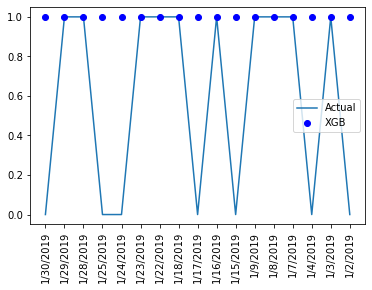

In [106]:
import matplotlib.pyplot as plt

x = test_news['Date']

plt.plot(x, test_news['Label'], label='Actual')
plt.plot(x, y_pred, 'bo', label='XGB')
#plt.plot(x, n3predictions, 'bo', label='Trigram')
#plt.plot(x, gbpredictions, 'bo', label='Gradient Boost')
#plt.plot(x, nbpredictions, 'bo', label='Naive Bayes')
#plt.plot(x, rfpredictions, 'bo', label='Random Forest')
#plt.plot(x, npredictions, 'bo', label='Logistic Regression')
#plt.plot(x, predictions, 'bo', label='Base')
plt.xticks(rotation=90)
plt.legend()
plt.show()